<a href="https://colab.research.google.com/github/basharbme/3D-Pelvic-Bone-cancer-classification/blob/main/Copy_of_Copy2_of_Pelvic_Bone_Tumour_3d_segmentation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SimpleITK==2.1.0
!pip install torchsummaryX
!pip install nibabel
!pip install pillow
!pip install tensorboard
!pip install gdown
!pip install pytorch-ignite==0.4.4
!pip install itk
!pip install tqdm
!pip install lmdb
!pip install psutil
!pip install pandas
!pip install einops
!pip install scikit-image
!pip install 'monai[all]'

     |████████████████████████████████| 48.4 MB 33 kB/s 
     |████████████████████████████████| 200 kB 11.8 MB/s 
     |████████████████████████████████| 16.6 MB 154 kB/s 
     |████████████████████████████████| 54.5 MB 8.4 kB/s 
     |████████████████████████████████| 15.0 MB 146 kB/s 
     |████████████████████████████████| 20.3 MB 10.6 MB/s 
     |████████████████████████████████| 70.6 MB 2.8 kB/s 
     |████████████████████████████████| 95.3 MB 12 kB/s 
     |████████████████████████████████| 650 kB 12.2 MB/s 
     |████████████████████████████████| 2.9 MB 41.2 MB/s 
     |████████████████████████████████| 4.9 MB 36.8 MB/s 
     |████████████████████████████████| 316 kB 40.2 MB/s 
     |████████████████████████████████| 221 kB 44.7 MB/s 
     |████████████████████████████████| 3.3 MB 41.8 MB/s 
     |████████████████████████████████| 895 kB 31.1 MB/s 
     |████████████████████████████████| 636 kB 40.1 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
  Created wheel f

In [ ]:
!pip install keras
import keras

In [ ]:
import os
import re
import argparse
import numpy as np
import random
import monai
import time
# from networks import build_net
import logging
import os
import sys
import tempfile
from glob import glob
from ignite.metrics import Accuracy
import nibabel as nib
import torch
import argparse
from monai.data import CacheDataset, DataLoader, Dataset
import SimpleITK as sitk
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.data import NiftiSaver, create_test_image_3d, list_data_collate
from collections import OrderedDict
from monai.handlers import (MeanDice, StatsHandler, ValidationHandler, CheckpointSaver, LrScheduleHandler, CheckpointLoader,
                         SegmentationSaver, TensorBoardImageHandler, TensorBoardStatsHandler)
from monai.inferers import SimpleInferer, SlidingWindowInferer
from monai.utils import set_determinism
import re
from monai.data import create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.transforms import (Activationsd,MeanEnsembled, GaussianSmoothd, CropForegroundd, ThresholdIntensityd, Activations,AsDiscrete, LoadImaged, AsChannelFirstd, VoteEnsembled, AsDiscreted, Compose, AddChanneld, Transpose, ConcatItemsd,
                              ScaleIntensityd, Resized,ToTensord, RandSpatialCropd, Rand3DElasticd, RandAffined, RandGaussianSmoothd, SpatialPadd,
    Spacingd, Orientationd, RandShiftIntensityd, BorderPadd, RandGaussianNoised, RandAdjustContrastd,NormalizeIntensityd,RandFlipd, KeepLargestConnectedComponent)

from monai.engines import (
    EnsembleEvaluator,
    SupervisedEvaluator,
    SupervisedTrainer
)

from skimage.measure import label
def getLargestCC(segmentation):
    labels = label(segmentation)
    unique, counts = np.unique(labels, return_counts=True)
    list_seg=list(zip(unique, counts))[1:] # the 0 label is by default background so take the rest
    largest=max(list_seg, key=lambda x:x[1])[0]
    labels_max=(labels == largest).astype(int)
    return labels_max


def Padding(image, reference):


    size_new = reference.GetSize()

    output_size = tuple(size_new)

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(reference.GetSpacing())
    resampler.SetSize(output_size)

    # resample on label
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetOutputOrigin(reference.GetOrigin())
    resampler.SetOutputDirection(reference.GetDirection())

    image = resampler.Execute(image)

    return image


def resize(img, new_size, interpolator):
    # img = sitk.ReadImage(img)
    dimension = img.GetDimension()

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    reference_physical_size[:] = [(sz - 1) * spc if sz * spc > mx else mx for sz, spc, mx in
                                  zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]

    # Create the reference image with a zero origin, identity direction cosine matrix and dimension
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()
    reference_size = new_size
    reference_spacing = [phys_sz / (sz - 1) for sz, phys_sz in zip(reference_size, reference_physical_size)]

    reference_image = sitk.Image(reference_size, img.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    # Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as
    # this takes into account size, spacing and direction cosines. For the vast majority of images the direction
    # cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the
    # spacing will not yield the correct coordinates resulting in a long debugging session.
    reference_center = np.array(
        reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize()) / 2.0))

    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))

    # centered_transform = sitk.Transform(transform)
    # centered_transform.AddTransform(centering_transform)

    centered_transform = sitk.CompositeTransform([transform, centering_transform])

    # Using the linear interpolator as these are intensity images, if there is a need to resample a ground truth
    # segmentation then the segmentation image should be resampled using the NearestNeighbor interpolator so that
    # no new labels are introduced.

    return sitk.Resample(img, reference_image, centered_transform, interpolator, 0.0)


def resample_sitk_image(sitk_image, spacing=None, interpolator=None, fill_value=0):
    # https://github.com/SimpleITK/SlicerSimpleFilters/blob/master/SimpleFilters/SimpleFilters.py
    _SITK_INTERPOLATOR_DICT = {
        'nearest': sitk.sitkNearestNeighbor,
        'linear': sitk.sitkLinear,
        'gaussian': sitk.sitkGaussian,
        'label_gaussian': sitk.sitkLabelGaussian,
        'bspline': sitk.sitkBSpline,
        'hamming_sinc': sitk.sitkHammingWindowedSinc,
        'cosine_windowed_sinc': sitk.sitkCosineWindowedSinc,
        'welch_windowed_sinc': sitk.sitkWelchWindowedSinc,
        'lanczos_windowed_sinc': sitk.sitkLanczosWindowedSinc
    }

    if isinstance(sitk_image, str):
        sitk_image = sitk.ReadImage(sitk_image)
    num_dim = sitk_image.GetDimension()

    if not interpolator:
        interpolator = 'linear'
        pixelid = sitk_image.GetPixelIDValue()

        if pixelid not in [1, 2, 4]:
            raise NotImplementedError(
                'Set `interpolator` manually, '
                'can only infer for 8-bit unsigned or 16, 32-bit signed integers')
        if pixelid == 1:  # 8-bit unsigned int
            interpolator = 'nearest'

    orig_pixelid = sitk_image.GetPixelIDValue()
    orig_origin = sitk_image.GetOrigin()
    orig_direction = sitk_image.GetDirection()
    orig_spacing = np.array(sitk_image.GetSpacing())
    orig_size = np.array(sitk_image.GetSize(), dtype=np.int)

    if not spacing:
        min_spacing = orig_spacing.min()
        new_spacing = [min_spacing] * num_dim
    else:
        new_spacing = [float(s) for s in spacing]

    assert interpolator in _SITK_INTERPOLATOR_DICT.keys(), \
        '`interpolator` should be one of {}'.format(_SITK_INTERPOLATOR_DICT.keys())

    sitk_interpolator = _SITK_INTERPOLATOR_DICT[interpolator]

    new_size = orig_size * (orig_spacing / new_spacing)
    new_size = np.ceil(new_size).astype(np.int)  # Image dimensions are in integers
    new_size = [int(s) for s in new_size]  # SimpleITK expects lists, not ndarrays

    resample_filter = sitk.ResampleImageFilter()

    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputDirection(orig_direction)
    resample_filter.SetOutputOrigin(orig_origin)
    resample_filter.SetTransform(sitk.Transform())
    resample_filter.SetDefaultPixelValue(orig_pixelid)
    resample_filter.SetInterpolator(sitk_interpolator)
    resample_filter.SetDefaultPixelValue(fill_value)

    resampled_sitk_image = resample_filter.Execute(sitk_image)

    return resampled_sitk_image


def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


def lstFiles(Path):

    images_list = []  # create an empty list, the raw image data files is stored here
    for dirName, subdirList, fileList in os.walk(Path):
        for filename in fileList:
            if ".nii.gz" in filename.lower():
                images_list.append(os.path.join(dirName, filename))
            elif ".nii" in filename.lower():
                images_list.append(os.path.join(dirName, filename))
            elif ".mhd" in filename.lower():
                images_list.append(os.path.join(dirName, filename))

    images_list = sorted(images_list, key=numericalSort)

    return images_list


def new_state_dict(file_name):
    state_dict = torch.load(file_name)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k[:6] == 'module':
            name = k[7:]
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


def new_state_dict_cpu(file_name):
    state_dict = torch.load(file_name, map_location='cpu')
    new_state_dict_cpu = OrderedDict()
    for k, v in state_dict.items():
        if k[:6] == 'module':
            name = k[7:]
            new_state_dict_cpu[name] = v
        else:
            new_state_dict_cpu[k] = v
    return new_state_dict_cpu


def from_numpy_to_itk(image_np, image_itk):

    # read image file
    reader = sitk.ImageFileReader()
    reader.SetFileName(image_itk)
    image_itk = reader.Execute()

    image_np = np.transpose(image_np, (2, 1, 0))
    image = sitk.GetImageFromArray(image_np)
    image.SetDirection(image_itk.GetDirection())
    image.SetSpacing(image_itk.GetSpacing())
    image.SetOrigin(image_itk.GetOrigin())
    return image


# function to keep track of the cropped area and coordinates
def statistics_crop(image, resolution):

    files = [{"image": image}]

    reader = sitk.ImageFileReader()
    reader.SetFileName(image)
    image_itk = reader.Execute()
    original_resolution = image_itk.GetSpacing()

    # original size
    transforms = Compose([
        LoadImaged(keys=['image']),
        AddChanneld(keys=['image']),
        ToTensord(keys=['image'])])
    data = monai.data.Dataset(data=files, transform=transforms)
    loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
    loader = monai.utils.misc.first(loader)
    im, = (loader['image'][0])
    vol = im.numpy()
    original_shape = vol.shape

    # cropped foreground size
    transforms = Compose([
        LoadImaged(keys=['image']),
        AddChanneld(keys=['image']),
        CropForegroundd(keys=['image'], source_key='image', start_coord_key='foreground_start_coord',
                        end_coord_key='foreground_end_coord', ),  # crop CropForeground
        ToTensord(keys=['image', 'foreground_start_coord', 'foreground_end_coord'])])

    data = monai.data.Dataset(data=files, transform=transforms)
    loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
    loader = monai.utils.misc.first(loader)
    im, coord1, coord2 = (loader['image'][0], loader['foreground_start_coord'][0], loader['foreground_end_coord'][0])
    vol = im[0].numpy()
    coord1 = coord1.numpy()
    coord2 = coord2.numpy()
    crop_shape = vol.shape

    if resolution is not None:

        transforms = Compose([
            LoadImaged(keys=['image']),
            AddChanneld(keys=['image']),
            CropForegroundd(keys=['image'], source_key='image'),  # crop CropForeground
            Spacingd(keys=['image'], pixdim=resolution, mode=('bilinear')),  # resolution
            ToTensord(keys=['image'])])

        data = monai.data.Dataset(data=files, transform=transforms)
        loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
        loader = monai.utils.misc.first(loader)
        im, = (loader['image'][0])
        vol = im.numpy()
        resampled_size = vol.shape

    else:

        resampled_size = original_shape

    return original_shape, crop_shape, coord1, coord2, resampled_size, original_resolution


def build_net_CT(patch_size,resolution):

    from monai.networks.layers import Norm

    sizes, spacings = patch_size, resolution

    strides, kernels = [], []

    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)
    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])

    # # create Unet

    nn_Unet = monai.networks.nets.DynUNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        kernel_size=kernels,
        strides=strides,
        upsample_kernel_size=strides[1:],
        res_block=True,
    )

    return nn_Unet


def crop_window(prostate_contour):
    # Cut data, restricted to the prostate contours + a pitch per direction per dimension.
    """
    nrrd has the following format, assuming to watch the patient from the front:
    (x, y, z)
    x: left to right (ascending)
    y: front to back (ascending)
    z: bottom to top (ascending)
    """
    pitch = 5
    pattern = np.where(prostate_contour == 1)

    minx = np.min(pattern[0]) - pitch
    maxx = np.max(pattern[0]) + pitch
    miny = np.min(pattern[1]) - pitch
    maxy = np.max(pattern[1]) + pitch
    minz = np.min(pattern[2]) - pitch
    maxz = np.max(pattern[2]) + pitch

    if (maxx - minx) % 2 != 0:
        maxx += 1
    if (maxy - miny) % 2 != 0:
        maxy += 1
    if (maxz - minz) % 2 != 0:
        maxz += 1

    """
    Choose all tensors to have size of 64x64x64
    """
    limit = 32

    while maxx - minx < limit:
        maxx += 1
        minx -= 1

    while maxy - miny < limit:
        maxy += 1
        miny -= 1

    while maxz - minz < limit:
        maxz += 1
        minz -= 1

    return minx, maxx, miny, maxy, minz, maxz


def uniform_img_dimensions(image, label, nearest):

    image_array = sitk.GetArrayFromImage(image)
    image_array = np.transpose(image_array, axes=(2, 1, 0))  # reshape array from itk z,y,x  to  x,y,z
    image_shape = image_array.shape

    if nearest is True:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='nearest')
        res = resize(label,image_shape,sitk.sitkNearestNeighbor)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('uint8'))
        # print(res.GetSize())

    else:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='linear')
        res = resize(label, image_shape, sitk.sitkLinear)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('float'))

    res.SetDirection(image.GetDirection())
    res.SetOrigin(image.GetOrigin())
    res.SetSpacing(image.GetSpacing())

    return image, res


def uniform_img_dimensions_internal(image, label, nearest):

    name_label = label

    image = sitk.ReadImage(image)
    label = sitk.ReadImage(label)
    image_array = sitk.GetArrayFromImage(image)
    image_array = np.transpose(image_array, axes=(2, 1, 0))  # reshape array from itk z,y,x  to  x,y,z
    image_shape = image_array.shape

    if nearest is True:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='nearest')
        res = resize(label,image_shape,sitk.sitkNearestNeighbor)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('uint8'))
        # print(res.GetSize())

    else:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='linear')
        res = resize(label, image_shape, sitk.sitkLinear)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('float'))

    res.SetDirection(image.GetDirection())
    res.SetOrigin(image.GetOrigin())
    res.SetSpacing(image.GetSpacing())

    sitk.WriteImage(res, name_label)


def normalize_PET(image_itk, value):

    # read image file
    image_np = sitk.GetArrayFromImage(image_itk)
    image_np = image_np/value
    image = sitk.GetImageFromArray(image_np)
    image.SetDirection(image_itk.GetDirection())
    image.SetSpacing(image_itk.GetSpacing())
    image.SetOrigin(image_itk.GetOrigin())
    return image


def processing_itk(label_CT, image_PET, label_PET, gluteus, new_resolution, patch_size):

    gluteus = sitk.ReadImage(gluteus)
    label_CT = sitk.ReadImage(label_CT)
    image_PET = sitk.ReadImage(image_PET)

    if label_PET is not None:
        label_PET = sitk.ReadImage(label_PET)

    if new_resolution is not None:
        image_PET = resample_sitk_image(image_PET, spacing=new_resolution, interpolator='linear')

    label_CT = Padding(label_CT, image_PET)
    gluteus = Padding(gluteus, image_PET)
    image_PET, label_CT = uniform_img_dimensions(image_PET, label_CT, True)
    image_PET, gluteus = uniform_img_dimensions(image_PET, gluteus, True)

    # new part for Pet tumor_background normalization

    gluteos_ROI_array = sitk.GetArrayFromImage(gluteus)
    gluteos_ROI_index = np.where(gluteos_ROI_array == 1)
    PET_array = sitk.GetArrayFromImage(image_PET)
    avg = np.mean(PET_array[gluteos_ROI_index])
    image_PET = normalize_PET(image_PET, avg)

    # end normalization

    if label_PET is not None:
        label_PET = Padding(label_PET, image_PET)
        image_PET, label_PET = uniform_img_dimensions(image_PET, label_PET, True)

    label_CT_array = sitk.GetArrayFromImage(label_CT)

    minx, maxx, miny, maxy, minz, maxz = crop_window(label_CT_array)

    roiFilter = sitk.RegionOfInterestImageFilter()
    roiFilter.SetSize(patch_size)
    roiFilter.SetIndex([int(minz), int(miny), int(minx)])

    label_CT = roiFilter.Execute(label_CT)
    image_PET = roiFilter.Execute(image_PET)

    if label_PET is not None:
        label_PET = roiFilter.Execute(label_PET)
    else:
        label_PET = None

    sitk.WriteImage(label_CT, 'mask_crop.nii')
    sitk.WriteImage(image_PET, 'result.nii')

    if label_PET is not None:

        sitk.WriteImage(label_PET, 'label_crop.nii')


def gaussian2(image):

    resacleFilter = sitk.RescaleIntensityImageFilter()
    resacleFilter.SetOutputMaximum(255)
    resacleFilter.SetOutputMinimum(0)
    image = resacleFilter.Execute(image)  # set intensity 0-255

    gaussianFilter = sitk.SmoothingRecursiveGaussianImageFilter()
    gaussianFilter.SetSigma(3)
    image = gaussianFilter.Execute(image)

    resacleFilter = sitk.RescaleIntensityImageFilter()
    resacleFilter.SetOutputMaximum(1)
    resacleFilter.SetOutputMinimum(0)
    image = resacleFilter.Execute(image)  # set intensity 0-255

    thresholdFilter = sitk.BinaryThresholdImageFilter()
    thresholdFilter.SetLowerThreshold(0.5)
    thresholdFilter.SetUpperThreshold(2)
    thresholdFilter.SetInsideValue(1)
    thresholdFilter.SetOutsideValue(0)
    image = thresholdFilter.Execute(image)

    return image

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [ ]:
import argparse
import os


class Options():

    """This class defines options used during both training and test time."""

    def __init__(self):
        """Reset the class; indicates the class hasn't been initailized"""
        self.initialized = False

    def initialize(self, parser):

        # basic parameters
        parser.add_argument('--images_folder', type=str, default='/content/drive/My Drive/Data_folder/images')
        parser.add_argument('--labels_folder', type=str, default='/content/drive/My Drive/Data_folder/labels')
        parser.add_argument('--increase_factor_data',  default=1, help='Increase data number per epoch')
        parser.add_argument('--preload', type=str, default=None)
        parser.add_argument('--gpu_ids', type=str, default='0,1', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        parser.add_argument('--workers', default=8, type=int, help='number of data loading workers')

        # dataset parameters
        parser.add_argument('--patch_size', default=(160, 160, 32), help='Size of the patches extracted from the image')
        parser.add_argument('--spacing', default=[2.25, 2.25, 3], help='Original Resolution')
        parser.add_argument('--resolution', default=None, help='New Resolution, if you want to resample the data in training. I suggest to resample in organize_folder_structure.py, otherwise in train resampling is slower')
        parser.add_argument('--batch_size', type=int, default=4, help='batch size, depends on your machine')
        parser.add_argument('--in_channels', default=1, type=int, help='Channels of the input')
        parser.add_argument('--out_channels', default=1, type=int, help='Channels of the output')

        # training parameters
        parser.add_argument('--epochs', default=1000, help='Number of epochs')
        parser.add_argument('--lr', default=0.01, help='Learning rate')

        self.initialized = True
        return parser

    def parse(self):
        if not self.initialized:
            parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)
        opt = parser.parse_args()
        # set gpu ids
        if opt.gpu_ids != '-1':
            os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpu_ids
        return opt







In [ ]:
import os
import re
import argparse
import SimpleITK as sitk
import numpy as np
import random
from utils import *
import sys


if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument('--images', default='/content/drive/My Drive/Data_folder/CT', help='path to the images')
    parser.add_argument('--labels', default='/content/drive/My Drive/Data_folder/CT_label', help='path to the labels')
    parser.add_argument('--split_val', default=30, help='number of images for validation')
    parser.add_argument('--split_test', default=30, help='number of images for testing')
    parser.add_argument('--resolution', default=[2.25, 2.25, 3], help='New Resolution to resample the data to same spacing')
    parser.add_argument('--smooth', default=False, help='Set True if you want to smooth a bit the binary mask')
    parser.add_argument('-f')
    args = parser.parse_args()

    list_images = lstFiles(args.images)
    list_labels = lstFiles(args.labels)

    mapIndexPosition = list(zip(list_images, list_labels))  
# shuffle order list
    random.shuffle(mapIndexPosition)
    list_images, list_labels = zip(*mapIndexPosition)

    os.mkdir('/content/drive/My Drive/Data_folder/images')
    os.mkdir('/content/drive/My Drive/Data_folder/labels')

    # 1
    if not os.path.isdir('/content/drive/My Drive/Data_folder/images/train'):
         os.mkdir('/content/drive/My Drive/Data_folder/images/train/')
    # 2
    if not os.path.isdir('/content/drive/My Drive/Data_folder/images/val'):
        os.mkdir('/content/drive/My Drive/Data_folder/images/val')

    # 3
    if not os.path.isdir('/content/drive/My Drive/Data_folder/images/test'):
        os.mkdir('/content/drive/My Drive/Data_folder/images/test')

    # 4
    if not os.path.isdir('/content/drive/My Drive/Data_folder/labels/train'):
        os.mkdir('/content/drive/My Drive/Data_folder/labels/train')

    # 5
    if not os.path.isdir('/content/drive/My Drive/Data_folder/labels/val'):
        os.mkdir('/content/drive/My Drive/Data_folder/labels/val')

    # 6
    if not os.path.isdir('/content/drive/My Drive/Data_folder/labels/test'):
        os.mkdir('/content/drive/My Drive/Data_folder/labels/test')

    for i in range(len(list_images)-int(args.split_test + args.split_val)):

        a = list_images[int(args.split_test + args.split_val)+i]
        b = list_labels[int(args.split_test + args.split_val)+i]

        print('train',i, a,b)

        label = sitk.ReadImage(b)
        image = sitk.ReadImage(a)

        image = resample_sitk_image(image, spacing=args.resolution, interpolator='linear', fill_value=0)
        image, label = uniform_img_dimensions(image, label, nearest=True)
        if args.smooth is True:
            label = gaussian2(label)

        image_directory = os.path.join('/content/drive/My Drive/Data_folder/images/train', -f"image{i:d}.nii")
        label_directory = os.path.join('/content/drive/My Drive/Data_folder/labels/train', -f"label{i:d}.nii")

        sitk.WriteImage(image, image_directory)
        sitk.WriteImage(label, label_directory)

     

     
        image = resample_sitk_image(image, spacing=args.resolution, interpolator='linear', fill_value=0)
        image, label = uniform_img_dimensions(image, label, nearest=True)
        if args.smooth is True:
            label = gaussian2(label)

        image_directory = os.path.join('/content/drive/My Drive/Data_folder/images/val', f"image{i:d}.nii")
        label_directory = os.path.join('/content/drive/My Drive/Data_folder/labels/val', f"label{i:d}.nii")

        sitk.WriteImage(image, image_directory)
        sitk.WriteImage(label, label_directory)

    for i in range(int(args.split_test)):

        a = list_images[i]
        b = list_labels[i]

        print('test',i,a,b)

        label = sitk.ReadImage(b)
        image = sitk.ReadImage(a)

        image = resample_sitk_image(image, spacing=args.resolution, interpolator='linear', fill_value=0)
        image, label = uniform_img_dimensions(image, label, nearest=True)
        if args.smooth is True:
            label = gaussian2(label)

        image_directory = os.path.join('/content/drive/My Drive/Data_folder/images/test', f"image{i:d}.nii")
        label_directory = os.path.join('/content/drive/My Drive/Data_folder/labels/test', f"label{i:d}.nii")

        sitk.WriteImage(image, image_directory)
        sitk.WriteImage(label, label_directory)



FileExistsError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from train import *
from torch.nn import init
import monai
from torch.optim import lr_scheduler
import sys
sys.argv=['']
del sys

def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm3d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    # print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def get_scheduler(optimizer, opt):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            # lr_l = 1.0 - max(0, epoch + 1 - opt.epochs/2) / float(opt.epochs/2 + 1)
            lr_l = (1 - epoch / opt.epochs) ** 0.9
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


# update learning rate (called once every epoch)
def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    # print('learning rate = %.7f' % lr)


from torch.nn import Module, Sequential
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d, Dropout3d
from torch.nn import ReLU, Sigmoid
import torch


def build_net():

    from init import Options
    opt = Options().parse()
    from monai.networks.layers import Norm

    # create nn-Unet
    if opt.resolution is None:
        sizes, spacings = opt.patch_size, opt.spacing
    else:
        sizes, spacings = opt.patch_size, opt.resolution

    strides, kernels = [], []

    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)
    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])

    # # create Unet

    nn_Unet = monai.networks.nets.DynUNet(
        spatial_dims=3,
        in_channels=opt.in_channels,
        out_channels=opt.out_channels,
        kernel_size=kernels,
        strides=strides,
        upsample_kernel_size=strides[1:],
        res_block=True,
    )

    init_weights(nn_Unet, init_type='normal')

    return nn_Unet


if __name__ == '__main__':
    import time
    import torch
    from torch.autograd import Variable
    from torchsummaryX import summary
    from torch.nn import init

    opt = Options().parse()

    torch.cuda.set_device(0)
    network = build_net()
    net = network.cuda().eval()

    data = Variable(torch.randn(1, int(opt.in_channels), int(opt.patch_size[0]), int(opt.patch_size[1]), int(opt.patch_size[2]))).cuda()

    out = net(data)

    torch.onnx.export(net, data, "Unet_model_graph.onnx")

    summary(net,data)
    print("out size: {}".format(out.size()))








                                                           Kernel Shape  \
Layer                                                                     
0_skip_layers.downsample.conv1.Conv3d_conv             [1, 32, 3, 3, 3]   
1_skip_layers.downsample.conv1.Conv3d_conv             [1, 32, 3, 3, 3]   
2_skip_layers.downsample.InstanceNorm3d_norm1                      [32]   
3_skip_layers.downsample.InstanceNorm3d_norm1                      [32]   
4_skip_layers.downsample.LeakyReLU_lrelu                              -   
5_skip_layers.downsample.LeakyReLU_lrelu                              -   
6_skip_layers.downsample.conv2.Conv3d_conv            [32, 32, 3, 3, 3]   
7_skip_layers.downsample.conv2.Conv3d_conv            [32, 32, 3, 3, 3]   
8_skip_layers.downsample.InstanceNorm3d_norm2                      [32]   
9_skip_layers.downsample.InstanceNorm3d_norm2                      [32]   
10_skip_layers.downsample.conv3.Conv3d_conv            [1, 32, 1, 1, 1]   
11_skip_layers.downsample

torch.Size([1, 160, 160, 32]) torch.Size([1, 160, 160, 32]) tensor([ 0, 12,  0]) tensor([169, 141, 168])
(160, 160, 32) (160, 160, 32)


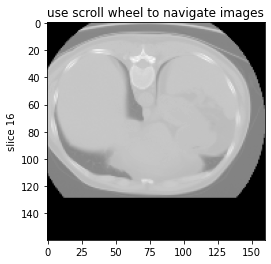

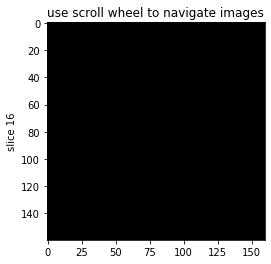

In [ ]:
import os
import sys
from glob import glob
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torch.utils.data import DataLoader
from init import Options
import monai
from monai.data import ArrayDataset, GridPatchDataset, create_test_image_3d
from monai.transforms import (Compose, LoadImaged, AddChanneld, Transpose, Resized, CropForegroundd, CastToTyped,RandGaussianSmoothd,
                              ScaleIntensityd, ToTensord, RandSpatialCropd, Rand3DElasticd, RandAffined, SpatialPadd,
    Spacingd, Orientationd, RandZoomd, ThresholdIntensityd, RandShiftIntensityd, RandGaussianNoised, BorderPadd,RandAdjustContrastd, NormalizeIntensityd,RandFlipd, ScaleIntensityRanged)


class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind],cmap= 'gray')
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


def plot3d(image):
    original=image
    original = np.rot90(original, k=-1)
    fig, ax = plt.subplots(1, 1)
    tracker = IndexTracker(ax, original)
    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
    plt.show()


if __name__ == "__main__":

    opt = Options().parse()

    train_images = sorted(glob(os.path.join(opt.images_folder, '/content/drive/My Drive/Data_folder/images/train', 'image*.nii')))
    train_segs = sorted(glob(os.path.join(opt.labels_folder, '/content/drive/My Drive/Data_folder/labels/train', 'label*.nii')))

    data_dicts = [{'image': image_name, 'label': label_name}
                  for image_name, label_name in zip(train_images, train_segs)]

    monai_transforms = [

        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),
        # ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
        CropForegroundd(keys=['image', 'label'], source_key='image', start_coord_key='foreground_start_coord',
                        end_coord_key='foreground_end_coord', ),  # crop CropForeground
        NormalizeIntensityd(keys=['image']),
        ScaleIntensityd(keys=['image']),
        # Spacingd(keys=['image', 'label'], pixdim=opt.resolution, mode=('bilinear', 'nearest')),

        SpatialPadd(keys=['image', 'label'], spatial_size=opt.patch_size, method= 'end'),
        RandSpatialCropd(keys=['image', 'label'], roi_size=opt.patch_size, random_size=False),
        ToTensord(keys=['image', 'label','foreground_start_coord', 'foreground_end_coord'],)
    ]

    transform = Compose(monai_transforms)
    check_ds = monai.data.Dataset(data=data_dicts, transform=transform)
    loader = DataLoader(check_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
    check_data = monai.utils.misc.first(loader)
    im, seg, coord1, coord2 = (check_data['image'][0], check_data['label'][0],check_data['foreground_start_coord'][0],
                      check_data['foreground_end_coord'][0])

    print(im.shape, seg.shape, coord1, coord2)

    vol = im[0].numpy()
    mask = seg[0].numpy()

    print(vol.shape, mask.shape)
    plot3d(vol)
    plot3d(mask)


In [ ]:


from init import Options
from networks import *
# from networks import build_net
import logging
import os
import sys
import tempfile
from glob import glob

import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (Compose, LoadImaged, AddChanneld, Transpose,Activations,AsDiscrete, RandGaussianSmoothd, CropForegroundd, SpatialPadd,
                              ScaleIntensityd, ToTensord, RandSpatialCropd, Rand3DElasticd, RandAffined, RandZoomd,
    Spacingd, Orientationd, Resized, ThresholdIntensityd, RandShiftIntensityd, BorderPadd, RandGaussianNoised, RandAdjustContrastd,NormalizeIntensityd,RandFlipd)

from monai.visualize import plot_2d_or_3d_image
# from monai.engines import get_devices_spec

def main():
    opt = Options().parse()
    # monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # check gpus
    if opt.gpu_ids != '-1':
        num_gpus = len(opt.gpu_ids.split(','))
    else:
        num_gpus = 0
    print('number of GPU:', num_gpus)

    # Data loader creation
    # train images
    train_images = sorted(glob(os.path.join(opt.images_folder, '/content/drive/My Drive/Data_folder/images/train', 'image*.nii')))
    train_segs = sorted(glob(os.path.join(opt.labels_folder, '/content/drive/My Drive/Data_folder/labels/train', 'label*.nii')))

    train_images_for_dice = sorted(glob(os.path.join(opt.images_folder, '/content/drive/My Drive/Data_folder/images/train', 'image*.nii')))
    train_segs_for_dice = sorted(glob(os.path.join(opt.labels_folder, '/content/drive/My Drive/Data_folder/labels/train', 'label*.nii')))

    # validation images
    val_images = sorted(glob(os.path.join(opt.images_folder, '/content/drive/My Drive/Data_folder/images/val', 'image*.nii')))
    val_segs = sorted(glob(os.path.join(opt.labels_folder, '/content/drive/My Drive/Data_folder/labels/val', 'label*.nii')))

    # test images
    test_images = sorted(glob(os.path.join(opt.images_folder, '/content/drive/My Drive/Data_folder/images/test', 'image*.nii')))
    test_segs = sorted(glob(os.path.join(opt.labels_folder, '/content/drive/My Drive/Data_folder/labels/test', 'label*.nii')))

    # augment the data list for training
    for i in range(int(opt.increase_factor_data)):
    
        train_images.extend(train_images)
        train_segs.extend(train_segs)

    print('Number of training patches per epoch:', len(train_images))
    print('Number of training images per epoch:', len(train_images_for_dice))
    print('Number of validation images per epoch:', len(val_images))
    print('Number of test images per epoch:', len(test_images))

    # Creation of data directories for data_loader

    train_dicts = [{'image': image_name, 'label': label_name}
                  for image_name, label_name in zip(train_images, train_segs)]

    train_dice_dicts = [{'image': image_name, 'label': label_name}
                   for image_name, label_name in zip(train_images_for_dice, train_segs_for_dice)]

    val_dicts = [{'image': image_name, 'label': label_name}
                   for image_name, label_name in zip(val_images, val_segs)]

    test_dicts = [{'image': image_name, 'label': label_name}
                 for image_name, label_name in zip(test_images, test_segs)]

    # Transforms list

    if opt.resolution is not None:
        train_transforms = [
            LoadImaged(keys=['image', 'label']),
            AddChanneld(keys=['image', 'label']),
            # ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),  # CT HU filter
            # ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
            CropForegroundd(keys=['image', 'label'], source_key='image'),               # crop CropForeground

            NormalizeIntensityd(keys=['image']),                                          # augmentation
            ScaleIntensityd(keys=['image']),                                              # intensity
            Spacingd(keys=['image', 'label'], pixdim=opt.resolution, mode=('bilinear', 'nearest')),  # resolution

            RandFlipd(keys=['image', 'label'], prob=0.15, spatial_axis=1),
            RandFlipd(keys=['image', 'label'], prob=0.15, spatial_axis=0),
            RandFlipd(keys=['image', 'label'], prob=0.15, spatial_axis=2),
            RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=0.1,
                        rotate_range=(np.pi / 36, np.pi / 36, np.pi * 2), padding_mode="zeros"),
            RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=0.1,
                        rotate_range=(np.pi / 36, np.pi / 2, np.pi / 36), padding_mode="zeros"),
            RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=0.1,
                        rotate_range=(np.pi / 2, np.pi / 36, np.pi / 36), padding_mode="zeros"),
            Rand3DElasticd(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=0.1,
                           sigma_range=(5, 8), magnitude_range=(100, 200), scale_range=(0.15, 0.15, 0.15),
                           padding_mode="zeros"),
            RandGaussianSmoothd(keys=["image"], sigma_x=(0.5, 1.15), sigma_y=(0.5, 1.15), sigma_z=(0.5, 1.15), prob=0.1,),
            RandAdjustContrastd(keys=['image'], gamma=(0.5, 2.5), prob=0.1),
            RandGaussianNoised(keys=['image'], prob=0.1, mean=np.random.uniform(0, 0.5), std=np.random.uniform(0, 15)),
            RandShiftIntensityd(keys=['image'], offsets=np.random.uniform(0,0.3), prob=0.1),

            SpatialPadd(keys=['image', 'label'], spatial_size=opt.patch_size, method= 'end'),  # pad if the image is smaller than patch
            RandSpatialCropd(keys=['image', 'label'], roi_size=opt.patch_size, random_size=False),
            ToTensord(keys=['image', 'label'])
        ]

        val_transforms = [
            LoadImaged(keys=['image', 'label']),
            AddChanneld(keys=['image', 'label']),
            # ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),
            # ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
            CropForegroundd(keys=['image', 'label'], source_key='image'),                   # crop CropForeground

            NormalizeIntensityd(keys=['image']),                                      # intensity
            ScaleIntensityd(keys=['image']),
            Spacingd(keys=['image', 'label'], pixdim=opt.resolution, mode=('bilinear', 'nearest')),  # resolution

            SpatialPadd(keys=['image', 'label'], spatial_size=opt.patch_size, method= 'end'),  # pad if the image is smaller than patch
            ToTensord(keys=['image', 'label'])
        ]
    else:
        train_transforms = [
            LoadImaged(keys=['image', 'label']),
            AddChanneld(keys=['image', 'label']),
            # ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),
            # ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
            CropForegroundd(keys=['image', 'label'], source_key='image'),               # crop CropForeground

            NormalizeIntensityd(keys=['image']),                                          # augmentation
            ScaleIntensityd(keys=['image']),                                              # intensity

            RandFlipd(keys=['image', 'label'], prob=0.15, spatial_axis=1),
            RandFlipd(keys=['image', 'label'], prob=0.15, spatial_axis=0),
            RandFlipd(keys=['image', 'label'], prob=0.15, spatial_axis=2),
            RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=0.1,
                        rotate_range=(np.pi / 36, np.pi / 36, np.pi * 2), padding_mode="zeros"),
            RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=0.1,
                        rotate_range=(np.pi / 36, np.pi / 2, np.pi / 36), padding_mode="zeros"),
            RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=0.1,
                        rotate_range=(np.pi / 2, np.pi / 36, np.pi / 36), padding_mode="zeros"),
            Rand3DElasticd(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=0.1,
                           sigma_range=(5, 8), magnitude_range=(100, 200), scale_range=(0.15, 0.15, 0.15),
                           padding_mode="zeros"),
            RandGaussianSmoothd(keys=["image"], sigma_x=(0.5, 1.15), sigma_y=(0.5, 1.15), sigma_z=(0.5, 1.15), prob=0.1,),
            RandAdjustContrastd(keys=['image'], gamma=(0.5, 2.5), prob=0.1),
            RandGaussianNoised(keys=['image'], prob=0.1, mean=np.random.uniform(0, 0.5), std=np.random.uniform(0, 1)),
            RandShiftIntensityd(keys=['image'], offsets=np.random.uniform(0,0.3), prob=0.1),

            SpatialPadd(keys=['image', 'label'], spatial_size=opt.patch_size, method= 'end'),  # pad if the image is smaller than patch
            RandSpatialCropd(keys=['image', 'label'], roi_size=opt.patch_size, random_size=False),
            ToTensord(keys=['image', 'label'])
        ]

        val_transforms = [
            LoadImaged(keys=['image', 'label']),
            AddChanneld(keys=['image', 'label']),
            # ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),
            # ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
            CropForegroundd(keys=['image', 'label'], source_key='image'),                   # crop CropForeground

            NormalizeIntensityd(keys=['image']),                                      # intensity
            ScaleIntensityd(keys=['image']),

            SpatialPadd(keys=['image', 'label'], spatial_size=opt.patch_size, method= 'end'),  # pad if the image is smaller than patch
            ToTensord(keys=['image', 'label'])
        ]

    train_transforms = Compose(train_transforms)
    val_transforms = Compose(val_transforms)

    # create a training data loader
    check_train = monai.data.Dataset(data=train_dicts, transform=train_transforms)
    train_loader = DataLoader(check_train, batch_size=opt.batch_size, shuffle=True, num_workers=opt.workers, pin_memory=False)

    # create a training_dice data loader
    check_val = monai.data.Dataset(data=train_dice_dicts, transform=val_transforms)
    train_dice_loader = DataLoader(check_val, batch_size=1, num_workers=opt.workers, pin_memory=False)

    # create a validation data loader
    check_val = monai.data.Dataset(data=val_dicts, transform=val_transforms)
    val_loader = DataLoader(check_val, batch_size=1, num_workers=opt.workers, pin_memory=False)

    # create a validation data loader
    check_val = monai.data.Dataset(data=test_dicts, transform=val_transforms)
    test_loader = DataLoader(check_val, batch_size=1, num_workers=opt.workers, pin_memory=False)

    # # try to use all the available GPUs
    # devices = get_devices_spec(None)

    # build the network
    net = build_net()
    net.cuda()

    if num_gpus > 1:
        net = torch.nn.DataParallel(net)

    if opt.preload is not None:
        net.load_state_dict(torch.load(opt.preload))

    dice_metric = DiceMetric(include_background=True, reduction="mean")
    post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

    loss_function = monai.losses.DiceCELoss(sigmoid=True)

    optim = torch.optim.SGD(net.parameters(), lr=opt.lr, momentum=0.99, weight_decay=3e-5, nesterov=True,)

    net_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optim, lr_lambda=lambda epoch: (1 - epoch / opt.epochs) ** 0.9)

    # start a typical PyTorch training
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(opt.epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{opt.epochs}")
        net.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["image"].cuda(), batch_data["label"].cuda()
            optim.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optim.step()
            epoch_loss += loss.item()
            epoch_len = len(check_train) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        update_learning_rate(net_scheduler, optim)

        if (epoch + 1) % val_interval == 0:
            net.eval()
            with torch.no_grad():

                def plot_dice(images_loader):

                    metric_sum = 0.0
                    metric_count = 0
                    val_images = None
                    val_labels = None
                    val_outputs = None
                    for data in images_loader:
                        val_images, val_labels = data["image"].cuda(), data["label"].cuda()
                        roi_size = opt.patch_size
                        sw_batch_size = 4
                        val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, net)
                        val_outputs = post_trans(val_outputs)
                        value = dice_metric(y_pred=val_outputs, y=val_labels)
                        metric_count += len(value)
                        metric_sum += value.item() * len(value)
                    metric = metric_sum / metric_count
                    metric_values.append(metric)
                    return metric, val_images, val_labels, val_outputs

                metric, val_images, val_labels, val_outputs = plot_dice(val_loader)

                # Save best model
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(net.state_dict(), "best_metric_model.pth")
                    print("saved new best metric model")

                metric_train, train_images, train_labels, train_outputs = plot_dice(train_dice_loader)
                metric_test, test_images, test_labels, test_outputs = plot_dice(test_loader)

                # Logger bar
                print(
                    "current epoch: {} Training dice: {:.4f} Validation dice: {:.4f} Testing dice: {:.4f} Best Validation dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric_train, metric, metric_test, best_metric, best_metric_epoch
                    )
                )

                writer.add_scalar("Mean_epoch_loss", epoch_loss, epoch + 1)
                writer.add_scalar("Testing_dice", metric_test, epoch + 1)
                writer.add_scalar("Training_dice", metric_train, epoch + 1)
                writer.add_scalar("Validation_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                # val_outputs = (val_outputs.sigmoid() >= 0.5).float()
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="validation image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="validation label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="validation inference")
                plot_2d_or_3d_image(test_images, epoch + 1, writer, index=0, tag="test image")
                plot_2d_or_3d_image(test_labels, epoch + 1, writer, index=0, tag="test label")
                plot_2d_or_3d_image(test_outputs, epoch + 1, writer, index=0, tag="test inference")

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()


if __name__ == "__main__":
    main()


number of GPU: 2
Number of training patches per epoch: 26
Number of training images per epoch: 13
Number of validation images per epoch: 6
Number of test images per epoch: 10


This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


----------
epoch 1/1000
1/6, train_loss: 0.9992
2/6, train_loss: 0.9956
3/6, train_loss: 0.9785
4/6, train_loss: 0.9952
5/6, train_loss: 0.9998
6/6, train_loss: 1.0000
7/6, train_loss: 0.9972
epoch 1 average loss: 0.9951
saved new best metric model
current epoch: 1 Training dice: 0.0039 Validation dice: 0.0004 Testing dice: 0.0013 Best Validation dice: 0.0004 at epoch 1
----------
epoch 2/1000
1/6, train_loss: 0.9987
2/6, train_loss: 1.0000
3/6, train_loss: 0.9998
4/6, train_loss: 0.9601
5/6, train_loss: 1.0000
6/6, train_loss: 1.0000
7/6, train_loss: 1.0000
epoch 2 average loss: 0.9941
saved new best metric model
current epoch: 2 Training dice: 0.0046 Validation dice: 0.0006 Testing dice: 0.0016 Best Validation dice: 0.0006 at epoch 2
----------
epoch 3/1000
1/6, train_loss: 0.9982
2/6, train_loss: 1.0000
3/6, train_loss: 0.9152
4/6, train_loss: 1.0000
5/6, train_loss: 0.9951
6/6, train_loss: 0.9970
7/6, train_loss: 1.0000
epoch 3 average loss: 0.9865
saved new best metric model
curre

KeyboardInterrupt: ignored

In [ ]:
from utils import *
import argparse
from networks import *
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.data import NiftiSaver, create_test_image_3d, list_data_collate


def segment(image, label, result, weights, resolution, patch_size, gpu_ids):

    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    if label is not None:
        uniform_img_dimensions_internal(image, label, True)
        files = [{"image": image, "label": label}]
    else:
        files = [{"image": image}]

    # original size, size after crop_background, cropped roi coordinates, cropped resampled roi size
    original_shape, crop_shape, coord1, coord2, resampled_size, original_resolution = statistics_crop(image, resolution)

    # -------------------------------

    if label is not None:
        if resolution is not None:

            val_transforms = Compose([
                LoadImaged(keys=['image', 'label']),
                AddChanneld(keys=['image', 'label']),
                ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),  # Threshold CT
                ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
                CropForegroundd(keys=['image', 'label'], source_key='image'),  # crop CropForeground

                NormalizeIntensityd(keys=['image']),  # intensity
                ScaleIntensityd(keys=['image']),
                Spacingd(keys=['image', 'label'], pixdim=resolution, mode=('bilinear', 'nearest')),  # resolution

                SpatialPadd(keys=['image', 'label'], spatial_size=patch_size, method= 'end'),
                ToTensord(keys=['image', 'label'])])
        else:

            val_transforms = Compose([
                LoadImaged(keys=['image', 'label']),
                AddChanneld(keys=['image', 'label']),
                ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),  # Threshold CT
                ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
                CropForegroundd(keys=['image', 'label'], source_key='image'),  # crop CropForeground

                NormalizeIntensityd(keys=['image']),  # intensity
                ScaleIntensityd(keys=['image']),

                SpatialPadd(keys=['image', 'label'], spatial_size=patch_size, method='end'),  # pad if the image is smaller than patch
                ToTensord(keys=['image', 'label'])])

    else:
        if resolution is not None:

            val_transforms = Compose([
                LoadImaged(keys=['image']),
                AddChanneld(keys=['image']),
                ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),  # Threshold CT
                ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
                CropForegroundd(keys=['image'], source_key='image'),  # crop CropForeground

                NormalizeIntensityd(keys=['image']),  # intensity
                ScaleIntensityd(keys=['image']),
                Spacingd(keys=['image'], pixdim=resolution, mode=('bilinear')),  # resolution

                SpatialPadd(keys=['image'], spatial_size=patch_size, method= 'end'),  # pad if the image is smaller than patch
                ToTensord(keys=['image'])])
        else:

            val_transforms = Compose([
                LoadImaged(keys=['image']),
                AddChanneld(keys=['image']),
                ThresholdIntensityd(keys=['image'], threshold=-135, above=True, cval=-135),  # Threshold CT
                ThresholdIntensityd(keys=['image'], threshold=215, above=False, cval=215),
                CropForegroundd(keys=['image'], source_key='image'),  # crop CropForeground

                NormalizeIntensityd(keys=['image']),  # intensity
                ScaleIntensityd(keys=['image']),

                SpatialPadd(keys=['image'], spatial_size=patch_size, method='end'), # pad if the image is smaller than patch
                ToTensord(keys=['image'])])

    val_ds = monai.data.Dataset(data=files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate, pin_memory=False)

    dice_metric = DiceMetric(include_background=True, reduction="mean")
    post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

    if gpu_ids != '-1':

        # try to use all the available GPUs
        os.environ['CUDA_VISIBLE_DEVICES'] = gpu_ids
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    else:
        device = torch.device("cpu")

    net = build_net()
    net = net.to(device)

    if gpu_ids == '-1':

        net.load_state_dict(new_state_dict_cpu(weights))

    else:

        net.load_state_dict(new_state_dict(weights))

    # define sliding window size and batch size for windows inference
    roi_size = patch_size
    sw_batch_size = 4

    net.eval()
    with torch.no_grad():

        if label is None:
            for val_data in val_loader:
                val_images = val_data["image"].cuda()
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, net)
                val_outputs = post_trans(val_outputs)
                # val_outputs = (val_outputs.sigmoid() >= 0.5).float()

        else:
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"].cuda(), val_data["label"].cuda()
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, net)
                val_outputs = post_trans(val_outputs)
                value, _ = dice_metric(y_pred=val_outputs, y=val_labels)
                metric_count += len(value)
                metric_sum += value.item() * len(value)
                # val_outputs = (val_outputs.sigmoid() >= 0.5).float()

            metric = metric_sum / metric_count
            print("Evaluation Metric (Dice):", metric)

        result_array = val_outputs.squeeze().data.cpu().numpy()
        # Remove the pad if the image was smaller than the patch in some directions
        result_array = result_array[0:resampled_size[0],0:resampled_size[1],0:resampled_size[2]]

        # resample back to the original resolution
        if resolution is not None:

            result_array_np = np.transpose(result_array, (2, 1, 0))
            result_array_temp = sitk.GetImageFromArray(result_array_np)
            result_array_temp.SetSpacing(resolution)

            # save temporary label
            writer = sitk.ImageFileWriter()
            writer.SetFileName('temp_seg.nii')
            writer.Execute(result_array_temp)

            files = [{"image": 'temp_seg.nii'}]

            files_transforms = Compose([
                LoadImaged(keys=['image']),
                AddChanneld(keys=['image']),
                Spacingd(keys=['image'], pixdim=original_resolution, mode=('nearest')),
                Resized(keys=['image'], spatial_size=crop_shape, mode=('nearest')),
            ])

            files_ds = Dataset(data=files, transform=files_transforms)
            files_loader = DataLoader(files_ds, batch_size=1, num_workers=0)

            for files_data in files_loader:
                files_images = files_data["image"]

                res = files_images.squeeze().data.numpy()

            result_array = np.rint(res)

            os.remove('./temp_seg.nii')

        # recover the cropped background before saving the image
        empty_array = np.zeros(original_shape)
        empty_array[coord1[0]:coord2[0],coord1[1]:coord2[1],coord1[2]:coord2[2]] = result_array

        result_seg = from_numpy_to_itk(empty_array, image)

        # save label
        writer = sitk.ImageFileWriter()
        writer.SetFileName(result)
        writer.Execute(result_seg)
        print("Saved Result at:", str(result))


if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument("--image", type=str, default='/content/drive/My Drive/Data_folder/images/train/image13.nii', help='source image' )
    parser.add_argument("--label", type=str, default=None, help='source label, if you want to compute dice. None for new case')
    parser.add_argument("--result", type=str, default='/content/drive/My Drive/Data_folder/test_2.nii', help='path to the .nii result to save')
    parser.add_argument("--weights", type=str, default='/content/best_metric_model.pth', help='network weights to load')
    parser.add_argument("--resolution", default=[2.25, 2.25, 3], help='Resolution used in training phase')
    parser.add_argument("--patch_size", type=int, nargs=3, default=(160, 160, 32), help="Input dimension for the generator, same of training")
    parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
    args = parser.parse_args()

    segment(args.image, args.label, args.result, args.weights, args.resolution, args.patch_size, args.gpu_ids)















usage: ipykernel_launcher.py [-h] [--image IMAGE] [--label LABEL]
                             [--result RESULT] [--weights WEIGHTS]
                             [--resolution RESOLUTION]
                             [--patch_size PATCH_SIZE PATCH_SIZE PATCH_SIZE]
                             [--gpu_ids GPU_IDS]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-7ee33397-119d-4321-9de0-2b4589603f65.json


SystemExit: ignored

To exit: use 'exit', 'quit', or Ctrl-D.
